In [1]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import matplotlib.cm
import scipy.stats
import pandas
import itertools
from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1
import time

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

# Determine number of "events" that happen per year, and then establish your return period of interest

In [2]:
working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'
#save_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calculations/npy_files/'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [3]:
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain_MONTHLY_TOTALS/'
#threshold=0.0
threshold=0.1
#threshold=0.5
#threshold=1.0
#threshold=5.0
#threshold=10.0

In [4]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

In [5]:
cali_coast_latlon_indices = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/coastal_latlon_array_indices_3x.npy')
cali_coast_latlon_indices_zip = [i for i in zip(cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1])]

cali_coast_latlon_indices_3d = cali_coast_latlon_indices.reshape((11,3,2))
#print(cali_coast_latlon_indices_3d[0,:,:])

# Open and save preindustrial control data

In [6]:
year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]

# create season strings
years_pic = numpy.arange(year_start_pic, year_end_pic+1, 1).astype(numpy.int)
half_years_pic = numpy.arange(year_start_pic+0.75, year_end_pic, 1)
#season_strings_pic = numpy.empty(years.size-1, dtype=numpy.str)

season_strings_pic = [str(years_pic[i])+'-'+str(years_pic[i+1]) for i in range(years_pic.size-1)]
member_strings_pic = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_pic=year_end_pic-year_start_pic

In [7]:
monthly_data_pic = numpy.load(working_dir+'member_005_years_0402-2200_threshold_0.1mmday_whole_domain.npy')

In [8]:
print(monthly_data_pic.shape)

(26, 25, 1799, 12)


In [9]:
monthly_pic_cali_coast = monthly_data_pic[cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1],:,:].reshape((11,3,1799,12))
monthly_pic_cali_coast_lonmean = numpy.mean(monthly_pic_cali_coast, axis=1)
monthly_pic_cali_coast_timemean = numpy.mean(monthly_pic_cali_coast_lonmean, axis=1)

In [10]:
# calculate standard error of the mean
monthly_pic_stdev = numpy.std(monthly_data_pic, axis=2, ddof=1)
monthly_pic_stderr = monthly_pic_stdev/numpy.sqrt(monthly_data_pic.shape[2]) # 26x25x5
monthly_pic_cali_coast_stderr = monthly_pic_stderr[cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1],:].reshape((11,3,-1))
monthly_pic_cali_coast_stderr_lonmean = numpy.mean(monthly_pic_cali_coast_stderr, axis=1)

In [11]:
print(monthly_pic_cali_coast_stderr_lonmean.shape)

(11, 12)


In [12]:
print(monthly_pic_stderr.shape)

(26, 25, 12)


# pic plot

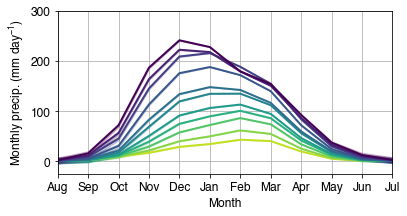

In [13]:
month_values = numpy.arange(1,13)
month_labels = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul']

# offset is the negative of 12-month_idx (so if you want calendar to begin on June, then it's -(12-6+1)=-7)
offset=-5
plot_array_pic = numpy.column_stack((monthly_pic_cali_coast_timemean[:,offset:], monthly_pic_cali_coast_timemean[:,:offset]))

fontsize=12
fig = mp.figure(figsize=(6,3))
ax = fig.add_subplot(111)
for i in range(11):
    
    ax.plot(month_values, plot_array_pic[i,:], color=matplotlib.cm.viridis_r((i+1)/11), lw=2)

    ax.fill_between(month_values, plot_array_pic[i,:]-monthly_pic_cali_coast_stderr_lonmean[i,:]*1.96, \
                    plot_array_pic[i,:]+monthly_pic_cali_coast_stderr_lonmean[i,:]*1.96, \
                    facecolor=matplotlib.cm.viridis_r((i+1)/11), \
                    edgecolor=matplotlib.cm.viridis_r((i+1)/11), \
                    alpha=0.25)

ax.set_xticks(month_values)
ax.set_xticklabels(month_labels, ha='center', va='top')
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('Monthly precip. (mm day$^{-1}$)', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)

ax.set_xlim(1,12)
ax.set_ylim(-25,300)

ax.grid()
ax.set_axisbelow(True)
fig.savefig('pic_monthly_precip_values.pdf', bbox_inches='tight', transparent=True)

# Open historical and RCP8.5 data

In [23]:
year_start = 1920
year_end = 2100

year_start_list = [1920,1950,1980,2010,2040,2070]
year_end_list = [1950,1980,2010,2040,2070,2100]

# create season strings
years = numpy.arange(year_start, year_end+1, 1).astype(numpy.int)
half_years_hist_rcp = numpy.arange(year_start+0.75, year_end, 1)

season_strings_hist_rcp = [str(years[i])+'-'+str(years[i+1]) for i in range(years.size-1)]
member_strings_hist_rcp = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_hist_rcp=year_end-year_start

In [24]:
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]
print(ensemble_names)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '101', '102', '103', '104', '105']


In [16]:
monthly_data_hist_rcp = []
for ens_name in ensemble_names:
    monthly_data_hist_rcp.append(numpy.load(working_dir+'PRECT_monthly_data_member_'+ens_name+'_years_1920-2100_threshold_0.1mmday_whole_domain.npy'))

In [17]:
monthly_data_hist_rcp = numpy.array((monthly_data_hist_rcp))
print(monthly_data_hist_rcp.shape)

(40, 26, 25, 181, 12)


# Saving in 4D format (latlon x ensemble member x years x month

do 151:181 for 2070-2100

and do 

In [25]:
monthly_hist_rcp_cali_coast = monthly_data_hist_rcp[:,cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1],:,:].reshape((40,11,3,181,12))
monthly_hist_rcp_cali_coast_lonmean = numpy.mean(monthly_hist_rcp_cali_coast, axis=2)
print(monthly_hist_rcp_cali_coast_lonmean.shape)
monthly_hist_rcp_cali_coast_timemean = numpy.mean(monthly_hist_rcp_cali_coast_lonmean[:,:,116:146,:], axis=2)
monthly_hist_rcp_cali_coast_enstimemean = numpy.mean(monthly_hist_rcp_cali_coast_timemean, axis=0)
print(monthly_hist_rcp_cali_coast_enstimemean.shape)

(40, 11, 181, 12)
(11, 12)


(11, 12)


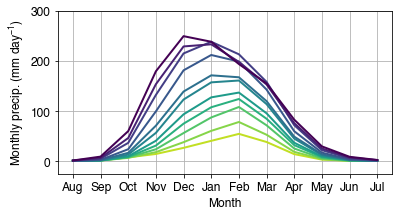

In [26]:
month_values = numpy.arange(1,13)
month_labels = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul']
print(monthly_hist_rcp_cali_coast_enstimemean.shape)

# offset is the negative of 12-month_idx (so if you want calendar to begin on June, then it's -(12-6+1)=-7)
offset=-5
plot_array_hist_rcp = numpy.column_stack((monthly_hist_rcp_cali_coast_enstimemean[:,offset:], monthly_hist_rcp_cali_coast_enstimemean[:,:offset]))
fontsize=12
fig = mp.figure(figsize=(6,3))
ax = fig.add_subplot(111)
for i in range(11):
    ax.plot(month_values, plot_array_hist_rcp[i,:], color=matplotlib.cm.viridis_r((i+1)/11), lw=2)

ax.set_xticks(month_values)
ax.set_xticklabels(month_labels, ha='center', va='top')
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('Monthly precip. (mm day$^{-1}$)', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)

#ax.set_xlim(1,6)
ax.set_ylim(-25,300)

ax.grid()

In [27]:
unique_lat_indices = numpy.unique(cali_coast_latlon_indices[:,0])

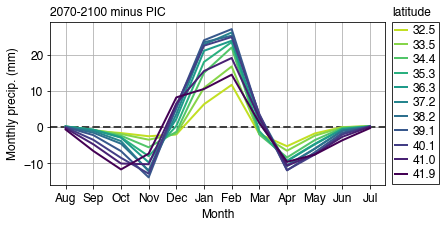

In [28]:
month_values = numpy.arange(1,13)
month_labels = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul']

fontsize=12
fig = mp.figure(figsize=(6,3))
ax = fig.add_subplot(111)
for i in range(11):
    ax.plot(month_values, plot_array_hist_rcp[i,:]-plot_array_pic[i,:], lw=2, color=matplotlib.cm.viridis_r((i+1)/11), label='{:.1f}'.format(PRECT_lat[unique_lat_indices][i]))

ax.axhline(y=0, lw=2, color='0.25', ls='--', zorder=1)

ax.set_xticks(month_values)
ax.set_xticklabels(month_labels, ha='center', va='top')
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('Monthly precip. (mm)', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, \
          fontsize=fontsize, \
          #ncol=2, \
          bbox_to_anchor=(1.02,1.0), \
          edgecolor='0', \
          facecolor='None', \
          fancybox=False, \
          bbox_transform=ax.transAxes, \
          loc='upper left', \
          borderaxespad=0, \
          borderpad=0.25, \
          handlelength=1.0, \
          handletextpad=0.5, \
          #columnspacing=0.5, \
          markerscale=1, \
          labelspacing=0.2)

ax.text(s='latitude', x=1.02, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='2070-2100 minus PIC', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-25,275)

ax.grid()
ax.set_axisbelow(True)

fig.savefig('monthly_precip_changes_1920-2100_minus_PIC.pdf', bbox_inches='tight', transparent=True)

# For 2070-2100 minus PIC

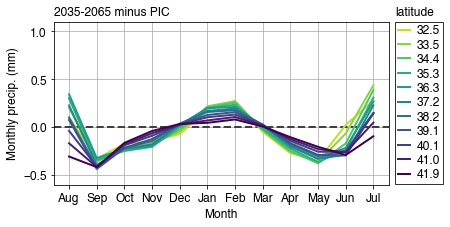

In [31]:
month_values = numpy.arange(1,13)
month_labels = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul']

fontsize=12
fig = mp.figure(figsize=(6,3))
ax = fig.add_subplot(111)
for i in range(11):
    ax.plot(month_values, (plot_array_hist_rcp[i,:]-plot_array_pic[i,:])/plot_array_pic[i,:], lw=2, color=matplotlib.cm.viridis_r((i+1)/11), label='{:.1f}'.format(PRECT_lat[unique_lat_indices][i]))

ax.axhline(y=0, lw=2, color='0.25', ls='--', zorder=1)

ax.set_xticks(month_values)
ax.set_xticklabels(month_labels, ha='center', va='top')
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('Monthly precip. (mm)', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylim(-.6,1.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, \
          fontsize=fontsize, \
          #ncol=2, \
          bbox_to_anchor=(1.02,1.0), \
          edgecolor='0', \
          facecolor='None', \
          fancybox=False, \
          bbox_transform=ax.transAxes, \
          loc='upper left', \
          borderaxespad=0, \
          borderpad=0.25, \
          handlelength=1.0, \
          handletextpad=0.5, \
          #columnspacing=0.5, \
          markerscale=1, \
          labelspacing=0.2)

ax.text(s='latitude', x=1.02, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='2035-2065 minus PIC', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-25,275)

ax.grid()
ax.set_axisbelow(True)

fig.savefig('monthly_precip_changes_2035-2065_minus_PIC_normalized.pdf', bbox_inches='tight', transparent=True)

# Save the longitudinally averaged data

In [32]:
print(monthly_hist_rcp_cali_coast_enstimemean[:,:].shape)
print(monthly_pic_cali_coast_timemean[:,:].shape)

(11, 12)
(11, 12)


In [33]:
lat_vals= PRECT_lat[unique_lat_indices]

In [34]:
month_strings = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
lat_strings = ['lat_'+'{:02d}'.format(i) for i in range(1,12)]

monthly_hist_rcp_cali_coast_df = pandas.DataFrame(numpy.column_stack((lat_vals, \
                                                  monthly_hist_rcp_cali_coast_enstimemean)), \
                                                  #index=range(1,lat_vals.size+1), \
                                                  columns=['lat_values']+month_strings)
monthly_pic_cali_coast_df = pandas.DataFrame(numpy.column_stack((lat_vals, \
                                                  monthly_pic_cali_coast_timemean)), \
                                                  #index=range(1,lat_vals.size+1), \
                                                  columns=['lat_values']+month_strings)

In [35]:
print(monthly_pic_cali_coast_df)

    lat_values     January    February       March      April        May  \
0    32.513089   34.344091   42.901914   40.249380  19.476946   5.024342   
1    33.455497   49.740727   61.467496   54.530659  25.241181   6.583004   
2    34.397906   72.296539   86.099103   73.663601  33.762199   9.538321   
3    35.340314   89.596308  100.573765   85.749288  41.392023  12.762161   
4    36.282723  106.245415  112.996682   94.395963  46.349262  14.466771   
5    37.225131  134.409102  134.737892  111.736465  55.852441  18.325987   
6    38.167539  147.774846  142.103709  116.384544  59.560190  19.746081   
7    39.109948  187.761743  171.633889  139.638590  71.770421  24.106540   
8    40.052356  215.605432  188.255442  154.496964  83.767002  29.686225   
9    40.994764  217.545950  178.902010  150.457196  86.602763  32.953248   
10   41.937173  227.603117  179.189502  153.782949  92.449812  37.205544   

         June      July    August  September    October    November  \
0    0.887789  0

In [36]:
monthly_hist_rcp_cali_coast_df.to_csv('csv_files/NDJFM_hist_rcp_cali_coast_values_'+str(2035)+'-'+str(2065)+'.csv')
#monthly_pic_cali_coast_df.to_csv('csv_files/NDJFM_pic_cali_coast_values.csv')